In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
%matplotlib inline
import collections
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.sparse as sp_sparse
import tables
import gc
import gzip
from scipy.sparse import coo_matrix
from sklearn.preprocessing import normalize
import pickle

# Load raw TCCs into memory

In [2]:
# tsvfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/UTR_TCC/TCC_output_UTR/matrix.tsv'
# COOinput = pd.read_csv( tsvfile_dir, delimiter='\t',header=None, dtype=int)

# A=COOinput.as_matrix()

# rows,cols,data = A.T

In [3]:
# nonzero_ec = np.unique(rows)
# map_rows = { val:ind for ind,val in enumerate( nonzero_ec ) }
# map_cols = { val:ind for ind,val in enumerate( np.unique(cols) ) }
# TCCmatrix   = coo_matrix( (data.astype(float),( [map_rows[r] for r in rows], [map_cols[c] for c in cols]) ) ) 

# NUM_OF_CELLS = TCCmatrix.shape[1]
# print("NUM_OF_CELLS =", NUM_OF_CELLS)
      
# T = TCCmatrix.tocsr()

In [4]:
# del TCCmatrix,map_cols,map_rows,A,rows,cols,data;
# _ = gc.collect()

In [5]:
# ecfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/UTR_TCC/TCC_output_UTR/matrix.ec'
# eclist=pd.read_csv( ecfile_dir, delimiter='\t',header=None, dtype=str)
# eclist=np.array(eclist)

In [6]:
# cellfile_dir = '/home/vasilis/clustering_EQ/10x_DATASETS/MemoryNaive/UTR_TCC/TCC_output_UTR/matrix.cells'
# celllist=pd.read_csv( cellfile_dir, delimiter='\t',header=None, dtype=str)
# print(celllist.iloc[123][0][10:-1])

In [7]:
# cellnames=[]
# for i in range(len(celllist.index)):
#     cellnames+=[celllist.iloc[i][0][10:-1]]
# cellnames=np.array(cellnames)

In [8]:
# #Save data
# with open("./TCC_matrix_MNC.dat", 'wb') as f:
#     pickle.dump(T,f)
# with open("./nonzero_ec_MNC.dat", 'wb') as f:
#     pickle.dump(nonzero_ec,f)
# with open("./eclist_MNC.dat", 'wb') as f:
#     pickle.dump(eclist,f)
# with open("./cellnames_MNC.dat", 'wb') as f:
#     pickle.dump(cellnames,f)
    


##  Load pickled TCCs

In [9]:
#Load dataset   
with open("./TCC_matrix_MNC.dat", 'rb') as f:
    T=pickle.load(f)
with open("./nonzero_ec_MNC.dat", 'rb') as f:
    nonzero_ec=pickle.load(f)
with open("./eclist_MNC.dat", 'rb') as f:
    eclist=pickle.load(f)
with open("./cellnames_MNC.dat", 'rb') as f:
    cellnames=pickle.load(f)

### quality control

In [10]:
# median umis per cell
print("median UMIs per cell:",np.median(np.array((np.sum(T,axis=0))).reshape(1,-1)[0]))

median UMIs per cell: 5248.0


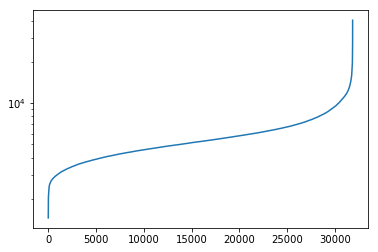

In [11]:
readspercell=np.array((np.sum(T,axis=0))).reshape(1,-1)[0]
plt.semilogy(np.sort(readspercell))

In [12]:
hi_low=[30000,1000]
cells_keep = np.where(readspercell<hi_low[0])[0]
idx = np.where(readspercell[cells_keep]>hi_low[1])[0]
cells_keep=cells_keep[idx]

In [13]:
cellnames = cellnames[cells_keep]

In [14]:
cells_keep.shape

(31831,)

In [15]:
T=T[:,cells_keep]

#### ECdict

In [16]:
EC_dict = {}
for i in range(np.shape(eclist)[0]):
    EC_dict[i] = [int(x) for x in eclist[i,1].split(',')]
    
union=set()
for i in nonzero_ec:
    new = [tx for tx in EC_dict[i] if tx not in union] # filter out previously seen transcripts
    union.update(new) 
union_list=np.sort(list(union)) #union of all transctipt ids seen in nonzero eq.classes
NUM_OF_TX_inTCC = len(union)
print("NUM_OF_Transcripts =", NUM_OF_TX_inTCC) #number of distinct transcripts in nonzero eq. classes 

NUM_OF_Transcripts = 133229


In [17]:
path_to_ref='./Homo_sapiens.GRCh38.rel79.cdna.all.utr_mod.fa.gz'

ENSG_PRPTC = 'ENSG00000262418'

def readENS_ids(path_to_ref):
    TX_to_ENST={}
    TX_to_ENSG={}
    ENSG_isoforms={}
    line_cnt=0;
    tx_cnt=0;
    with gzip.open(path_to_ref) as f:
        for line in f:
            if line.decode('UTF-8')[0]=='>':
                liner=line.decode('UTF-8')
                if line_cnt == union_list[tx_cnt]:
                    if liner.split("ENST",1)[1][11:].startswith('_utr_mod'):
                        TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:20]
                        TX_to_ENSG[union_list[tx_cnt]] = ENSG_PRPTC
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                        tx_cnt+=1 
                    else:
                        TX_to_ENST[union_list[tx_cnt]] = 'ENST'+liner.split("ENST",1)[1][:11]
                        TX_to_ENSG[union_list[tx_cnt]] = 'ENSG'+liner.split("ENSG",1)[1][:11]
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]] = ENSG_isoforms.get(TX_to_ENSG[union_list[tx_cnt]], [])
                        ENSG_isoforms[TX_to_ENSG[union_list[tx_cnt]]].append(TX_to_ENST[union_list[tx_cnt]])
                        tx_cnt+=1 
                    if tx_cnt==NUM_OF_TX_inTCC: return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]
                line_cnt+=1
    return [TX_to_ENST,TX_to_ENSG,ENSG_isoforms]


[TX_to_ENST,TX_to_ENSG,ENSG_isoforms]=readENS_ids(path_to_ref)       

In [18]:
EC_ENST_DICT={}
EC_ENSG_DICT={}
for ec in nonzero_ec:
    EC_ENST_DICT[ec] = [TX_to_ENST[tx] for tx in EC_dict[ec]]    
    EC_ENSG_DICT[ec] = list(np.unique([TX_to_ENSG[tx] for tx in EC_dict[ec]])) 

In [19]:
ENST_to_TX = {v: k for k, v in TX_to_ENST.items()}

In [20]:
#inv_map ; NOTE: genes and transcripts may be associated with multiple ensg accession numbers
ENSG_EC_DICT={}
for k, v in EC_ENSG_DICT.items():
    for vi in v:
        ENSG_EC_DICT[vi] = ENSG_EC_DICT.get(vi, [])
        ENSG_EC_DICT[vi].append(k)
        
ENST_EC_DICT={}
for k, v in EC_ENST_DICT.items():
    for vi in v:
        ENST_EC_DICT[vi] = ENST_EC_DICT.get(vi, [])
        ENST_EC_DICT[vi].append(k)

In [21]:
all_genes_ids = np.unique(list(TX_to_ENSG.values()))
print("NUM_OF_GENE_IDs =", len(all_genes_ids))

NUM_OF_GENE_IDs = 25940


In [22]:
clean_gene_ids=[]

for gene in all_genes_ids:
    if len(list(np.unique([EC_ENSG_DICT[ec] for ec in ENSG_EC_DICT[gene]]))) == 1:
        clean_gene_ids+=[gene]
clean_gene_ids=np.array(clean_gene_ids)

In [23]:
print("NUM_OF_CLEAN_GENE_IDs =", len(clean_gene_ids))

NUM_OF_CLEAN_GENE_IDs = 6234


#### gene names

In [24]:
# #gene ids to gene names (requires "pip install mygene")
# import mygene
# mg = mygene.MyGeneInfo()
# ginfo = mg.querymany(all_genes_ids, scopes='ensembl.gene',returnall=True)

# with open('ginfo_MNC.pickle', 'wb') as handle:
#     pickle.dump(ginfo, handle, protocol=pickle.HIGHEST_PROTOCOL)

#LOAD
with open('./ginfo_MNC.pickle', 'rb') as handle:
    ginfo = pickle.load(handle)

In [25]:
missing_names=ginfo['missing']
duplicate_names=ginfo['dup']

In [26]:
#ENSG to Gene-Names
all_gene_id_to_names={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        ensg_id=str(g['query'])
        all_gene_id_to_names[ensg_id] = all_gene_id_to_names.get(ensg_id, [])
        all_gene_id_to_names[ ensg_id].append(str(g['symbol']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_id_to_names[ str(g['query']) ] = [str(g['query'])]
        
#Gene-Names to ENSG
all_gene_names_to_id={} #missing are mapped to their ENSG id, Duplicates to a list of names
count_exept=0
for g in ginfo['out']:
    try:
        gene_name=str(g['symbol'])
        all_gene_names_to_id[gene_name] = all_gene_names_to_id.get(gene_name, [])
        all_gene_names_to_id[ gene_name].append(str(g['query']))                
    except KeyError:
        count_exept=count_exept+1
        all_gene_names_to_id[ str(g['query']) ] = [str(g['query'])]

In [27]:
def search_gene(starting_letters):
    print("SEARCHING: ",starting_letters,"...")
    for gene in all_genes_ids:
        if all_gene_id_to_names[gene][0][:len(starting_letters)] == starting_letters:
            print(gene,all_gene_id_to_names[gene])
    print("DONE")

In [28]:
EC_IDX={}
for i in range(len(nonzero_ec)):
    EC_IDX[nonzero_ec[i]] =i 

# PTPRC

In [29]:
gene="PTPRC"
all_gene_names_to_id[gene]

['ENSG00000081237', 'ENSG00000262418']

In [30]:
ENSG_isoforms['ENSG00000262418']

['ENST00000573298',
 'ENST00000575923',
 'ENST00000573679',
 'ENST00000574399',
 'ENST00000576833',
 'ENST00000573477',
 'ENST00000570609',
 'ENST00000571847',
 'ENST00000574441',
 'ENST00000573971',
 'ENST00000572593',
 'ENST00000574718',
 'ENST00000570905',
 'ENST00000575803',
 'ENST00000442510_utr_mod1',
 'ENST00000348564_utr_mod1',
 'ENST00000575923_utr_mod2',
 'ENST00000573679_utr_mod2',
 'ENST00000576833_utr_mod2',
 'ENST00000573477_utr_mod2',
 'ENST00000574441_utr_mod2',
 'ENST00000530727_utr_mod2',
 'ENST00000442510_utr_mod2',
 'ENST00000367367_utr_mod2',
 'ENST00000348564_utr_mod2',
 'ENST00000529828_utr_mod2',
 'ENST00000442510_utr_mod3',
 'ENST00000367367_utr_mod3',
 'ENST00000348564_utr_mod3',
 'ENST00000529828_utr_mod3',
 'ENST00000442510_utr_mod4',
 'ENST00000348564_utr_mod4']

In [31]:
gene_ecs0=[]
for g in all_gene_names_to_id[gene]:
    gene_ecs0+=ENSG_EC_DICT[g]
gene_ecs0=np.unique(gene_ecs0)

In [32]:
gene_ecs0

array([185843, 199837, 211377, 224177, 232679, 238975, 246521, 247041,
       250063, 250948, 252827, 260786, 274849, 288032, 297189, 314731,
       330794, 364482, 428758, 512173, 572158, 577227, 599469, 599470,
       599471, 599472, 599473, 599474, 615896, 615897, 656377, 658951,
       658952, 658953, 658954, 658955, 689611, 712851, 713764, 715535,
       722169, 745960])

In [33]:
ec_counts=[]
for ec in gene_ecs0:
    ec_counts+=[T[EC_IDX[ec],:].sum()]
ec_nnz_cell_counts=[]
for ec in gene_ecs0:
    ec_nnz_cell_counts+=[T[EC_IDX[ec],:].nnz] 
    

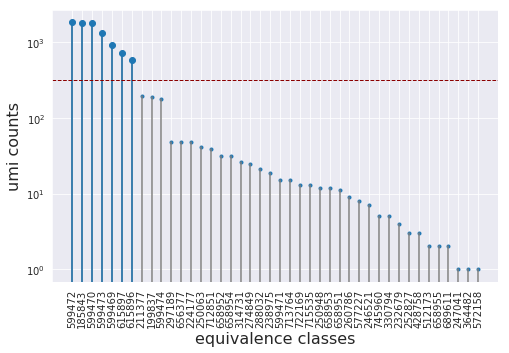

In [34]:
sns.set_style("darkgrid")

threshold=0.01*T.shape[1]

gene_ecs=gene_ecs0[np.where(np.array(ec_counts)>threshold)[0]]
upto=len(gene_ecs)

plt.figure(figsize=(8,5))
plt.stem(range(len(ec_counts)),np.sort(ec_counts)[::-1],'gray',markerfmt='.')

plt.xticks(range(len(ec_counts)),gene_ecs0[np.argsort(ec_counts)[::-1]],rotation='vertical')
# plt.xlim([0,len(b)+0.9])

plt.stem(range(upto),np.sort(ec_counts)[::-1][:upto])

plt.axhline(y=threshold, color='darkred', linestyle='--',linewidth=1)
plt.xlabel("equivalence classes",fontsize=16)
plt.ylabel("umi counts",fontsize=16)
plt.yscale('log')
plt.show()

In [35]:
print(gene_ecs)

[185843 599469 599470 599472 599473 615896 615897]


In [36]:
associated_genes=[]
for ec in gene_ecs:
    associated_genes += [all_gene_id_to_names[ens][0] for ens in EC_ENSG_DICT[ec]]
associated_genes=np.unique(associated_genes)
print(associated_genes)

['PTPRC']


In [37]:
ecidx=np.array([EC_IDX[ec] for ec in gene_ecs])

In [38]:
ecidx

array([ 62333, 214260, 214261, 214263, 214264, 223216, 223217])

In [39]:
eq_classes=[]
for i in ecidx:
    tx_indices=EC_dict[nonzero_ec[i]]
    tx_ens=[TX_to_ENST[t] for t in tx_indices]
    eq_classes+=[tx_ens]

In [40]:
import json
eq_dict={}
for i in range(len(eq_classes)):
    eq_dict[str(gene_ecs[i])] = list(np.sort(eq_classes[i]))
print(json.dumps(eq_dict, indent=1))

{
 "185843": [
  "ENST00000348564",
  "ENST00000442510"
 ],
 "599469": [
  "ENST00000348564",
  "ENST00000348564_utr_mod4",
  "ENST00000442510",
  "ENST00000442510_utr_mod4"
 ],
 "599470": [
  "ENST00000348564",
  "ENST00000348564_utr_mod1",
  "ENST00000348564_utr_mod4",
  "ENST00000442510",
  "ENST00000442510_utr_mod1",
  "ENST00000442510_utr_mod4"
 ],
 "599472": [
  "ENST00000348564",
  "ENST00000348564_utr_mod1",
  "ENST00000348564_utr_mod3",
  "ENST00000348564_utr_mod4",
  "ENST00000367367",
  "ENST00000367367_utr_mod3",
  "ENST00000442510",
  "ENST00000442510_utr_mod1",
  "ENST00000442510_utr_mod3",
  "ENST00000442510_utr_mod4",
  "ENST00000529828",
  "ENST00000529828_utr_mod3"
 ],
 "599473": [
  "ENST00000348564",
  "ENST00000348564_utr_mod1",
  "ENST00000348564_utr_mod3",
  "ENST00000348564_utr_mod4",
  "ENST00000367367",
  "ENST00000367367_utr_mod3",
  "ENST00000442510",
  "ENST00000442510_utr_mod1",
  "ENST00000442510_utr_mod3",
  "ENST00000442510_utr_mod4",
  "ENST00000529828

# LogR

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import statsmodels.api as sm
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import math

In [42]:
labels=[]
for name in cellnames:
    if name[-1]=='N':
        labels+=[0]
    elif name[-1]=='M':
        labels+=[1]
    else:
        labels+=[2]
labels=np.array(labels)

In [43]:
def logr_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    c=np.concatenate([X1_ecidx,X2_ecidx])
    #c=np.concatenate([X1[:,ecidx],X2[:,ecidx]])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]

In [44]:
X=T.T

In [45]:
X_naive=X[np.squeeze(labels==0),:]
X_mem=X[np.squeeze(labels==1),:]
X_cyto=X[np.squeeze(labels==2),:]




print("naive cells: ",X_naive.shape[0])
print("mem cells: ",X_mem.shape[0])
print("cyto cells: ",X_cyto.shape[0])

naive cells:  9923
mem cells:  9994
cyto cells:  11914


In [46]:
np.random.seed(0)
samples=3000

randperm1=np.random.permutation(X_naive.shape[0])
randperm2=np.random.permutation(X_mem.shape[0])
randperm3=np.random.permutation(X_cyto.shape[0])

In [47]:
sns.set_style("white")

(3000, 342642)
(3000, 342642)
pval= 1.52548615028e-05


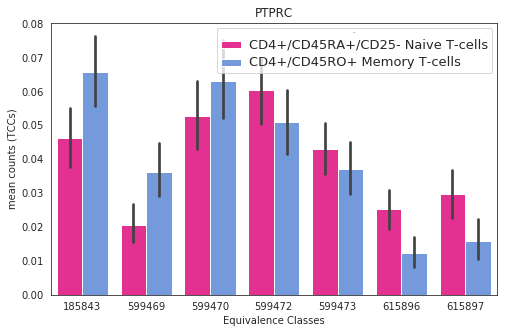

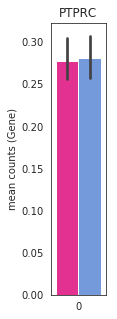

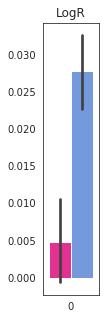

In [48]:
#positive control 

X1=X_naive[randperm1[:samples],:]
X2=X_mem[randperm2[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()


E_naive_mean = np.array(np.mean(X1[:,ecidx],axis=0))[0]
E_mem_mean = np.array(np.mean(X2[:,ecidx],axis=0))[0]

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

G_naive_mean = np.mean(Gexp1)
G_mem_mean = np.mean(Gexp2)

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()


A1=np.array(np.dot(X1_ecidx,-A[0].coef_[0]))[0]
A2=np.array(np.dot(X2_ecidx,-A[0].coef_[0]))[0]

P1=pd.DataFrame(A1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(A2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#6495ED"], data=df)
ax.set(xlabel='', ylabel='')
ax.legend_.remove()
plt.title("LogR")
plt.show()


Optimization terminated successfully.
         Current function value: 0.690289
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Mon, 05 Nov 2018   Pseudo R-squ.:                0.004124
Time:                        15:52:06   Log-Likelihood:                -4141.7
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 1.512e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0165      0.028      0.592      0.554      -0.038       0.071
x1            -0.2808      0.

<Container object of 3 artists>

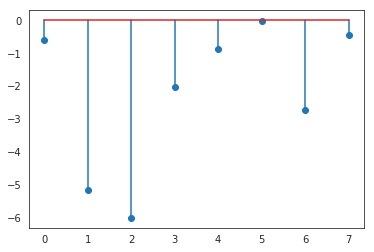

In [49]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342642)
(3000, 342642)
pval= 0.754000869406


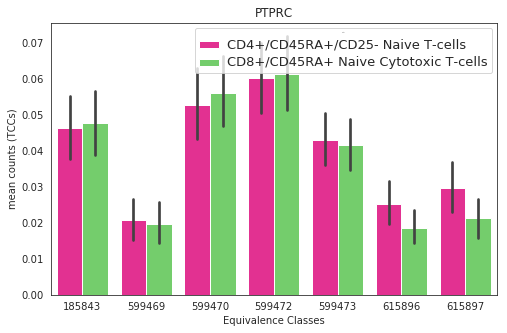

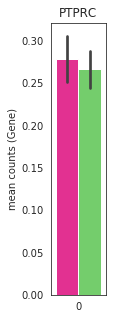

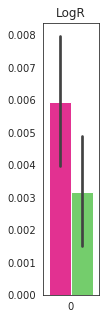

In [50]:
#negative control 

X1=X_naive[randperm1[:samples],:]
X2=X_cyto[randperm3[:samples],:]


print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()


E_cyto_mean = np.array(np.mean(X2[:,ecidx],axis=0))[0]

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

G_cyto_mean = np.mean(Gexp2)

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()


A1=np.array(np.dot(X1_ecidx,A[0].coef_[0]))[0]
A2=np.array(np.dot(X2_ecidx,A[0].coef_[0]))[0]

P1=pd.DataFrame(A1.T,)
P1['cluster'] = 'CD4+/CD45RA+/CD25- Naive T-cells'
P2=pd.DataFrame(A2.T)
P2['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')


plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#FF1493", "#66dd5c"], data=df)
ax.set(xlabel='', ylabel='')
ax.legend_.remove()
plt.title("LogR")
plt.show()

Optimization terminated successfully.
         Current function value: 0.692795
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Mon, 05 Nov 2018   Pseudo R-squ.:               0.0005076
Time:                        15:52:09   Log-Likelihood:                -4156.8
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                    0.7538
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0046      0.028     -0.164      0.870      -0.059       0.050
x1            -0.0193      0.

<Container object of 3 artists>

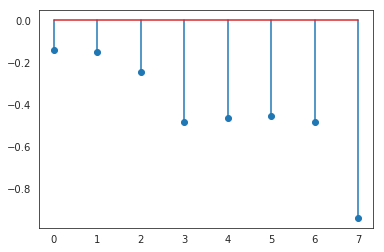

In [51]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

(3000, 342642)
(3000, 342642)
pval= 0.000484202196512


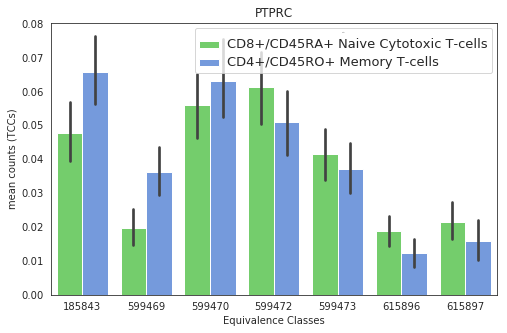

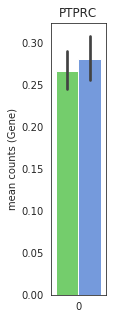

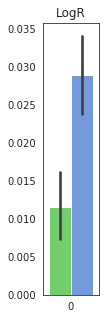

In [52]:
#positive control 

X1=X_cyto[randperm3[:samples],:]
X2=X_mem[randperm2[:samples],:]



print(X1.shape)
print(X2.shape)

N1=X1.shape[0]
N2=X2.shape[0]


A=logr_ecidx(ecidx,X1,X2)
print('pval=',A[1])


X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()

P1=pd.DataFrame(X1_ecidx,columns=nonzero_ec[ecidx])
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(X2_ecidx,columns=nonzero_ec[ecidx])
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(8,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='Equivalence Classes', ylabel='mean counts (TCCs)')
plt.title(gene)
plt.setp(ax.get_legend().get_texts(), fontsize='13') 
plt.setp(ax.get_legend().get_title(), fontsize='0')
plt.show()


Gexp1=np.array(X1_ecidx.T.sum(axis=0))[0]
Gexp2=np.array(X2_ecidx.T.sum(axis=0))[0]

P1=pd.DataFrame(Gexp1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(Gexp2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')

plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='mean counts (Gene)')
ax.legend_.remove()
plt.title(gene)
plt.show()


A1=np.array(np.dot(X1_ecidx,-A[0].coef_[0]))[0]
A2=np.array(np.dot(X2_ecidx,-A[0].coef_[0]))[0]

P1=pd.DataFrame(A1.T,)
P1['cluster'] = 'CD8+/CD45RA+ Naive Cytotoxic T-cells'
P2=pd.DataFrame(A2.T)
P2['cluster'] = 'CD4+/CD45RO+ Memory T-cells'
P=P1.append(P2)
df = pd.melt(P,  id_vars='cluster')


plt.figure(figsize=(1,5))
ax=sns.barplot(x='variable', y='value', hue='cluster',palette=["#66dd5c","#6495ED"], data=df)
ax.set(xlabel='', ylabel='')
ax.legend_.remove()
plt.title("LogR")
plt.show()

Optimization terminated successfully.
         Current function value: 0.690971
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6000
Model:                          Logit   Df Residuals:                     5992
Method:                           MLE   Df Model:                            7
Date:                Mon, 05 Nov 2018   Pseudo R-squ.:                0.003140
Time:                        15:52:12   Log-Likelihood:                -4145.8
converged:                       True   LL-Null:                       -4158.9
                                        LLR p-value:                 0.0004794
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0200      0.028      0.716      0.474      -0.035       0.075
x1            -0.2585      0.

<Container object of 3 artists>

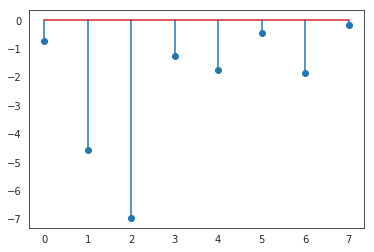

In [53]:
N1=X1.shape[0]
N2=X2.shape[0]
logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)

X1_ecidx=X1[:,ecidx].todense()
X2_ecidx=X2[:,ecidx].todense()
c=np.concatenate([X1_ecidx,X2_ecidx])
c=np.concatenate([np.ones((N1+N2,1)),c],axis=1)
logit = sm.Logit( logr_labels,c)


# fit the model
result = logit.fit()
print( result.summary())
print(result.wald_test_terms())
plt.stem(np.log(result.pvalues))

In [54]:
from scipy.stats import ttest_ind

def ttest_ecidx(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    
    k=len(ecidx)
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    
    pvals=[]
    for j in range(k):
        a=X1_ecidx[:,j]
        b=X2_ecidx[:,j]
        [o,p]=ttest_ind(a,b,equal_var=False)
        pvals+=[p]
    pval=np.min([1,np.min(np.array(pvals))*k])
    g1=np.sum(X1_ecidx,axis=1)
    g2=np.sum(X2_ecidx,axis=1)
    [o,gene_pval]=ttest_ind(g1,g2,equal_var=False)
    all_pvals=np.array([np.min([1,k*p]) for p in pvals])
    return pval,all_pvals,gene_pval[0]


def logr_gene(ecidx,X1,X2):
    
    N1=X1.shape[0]
    N2=X2.shape[0]
    logr_labels = np.concatenate((np.ones(N1),np.zeros(N2)),axis=0)
    logr = LogisticRegression()
    p_of_1=N1/float(N1+N2)
    llnull=(N1+N2)*(p_of_1*np.log(p_of_1) + (1-p_of_1)*np.log(1-p_of_1))
  
    k=1
    
    X1_ecidx=X1[:,ecidx].todense()
    X2_ecidx=X2[:,ecidx].todense()
    
    g1=np.sum(X1_ecidx,axis=1)
    g2=np.sum(X2_ecidx,axis=1)
    
    c=np.concatenate([g1,g2])
    logr.fit(c,logr_labels)
    pred=np.array(logr.predict_proba(c)[:,1])
    gene_score=log_loss(logr_labels,pred)
    llf=-gene_score*(N1+N2)
    llr=llf-llnull
    llr_pval = 1-stats.chi2.cdf(2*llr,k)
    
    return [logr,llr_pval]


def logr_indep(ecidx,X1,X2):
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    all_pvals=np.array([np.min([1,p*len(ecidx)]) for p in pvals_tmp])
    
    return [all_pvals,pval_sep]

In [55]:
print('--------mem/naive----------')
X1=X_naive[randperm1[:samples],:]
X2=X_mem[randperm2[:samples],:]
aA1=logr_ecidx(ecidx,X1,X2)
bB1=logr_gene(ecidx,X1,X2)
cC1=logr_indep(ecidx,X1,X2)
print('-log10_GENE-pval=',-np.log10(bB1[1]))
print('-log10_LOGR-pval=',-np.log10(aA1[1]))
print('-log10_INDT-pval_min=',-np.log10(cC1[1]))
print('-log10_INDT-pvals=\n',-np.log10(cC1[0]))

print('--------cyto/mem----------')
X1=X_cyto[randperm3[:samples],:]
X2=X_mem[randperm2[:samples],:]
aA2=logr_ecidx(ecidx,X1,X2)
bB2=logr_gene(ecidx,X1,X2)
cC2=logr_indep(ecidx,X1,X2)
print('-log10_GENE-pval=',-np.log10(bB2[1]))
print('-log10_LOGR-pval=',-np.log10(aA2[1]))
print('-log10_INDT-pval_min=',-np.log10(cC2[1]))
print('-log10_INDT-pvals=\n',-np.log10(cC2[0]))

print('--------naive/cyto----------')
X1=X_naive[randperm1[:samples],:]
X2=X_cyto[randperm3[:samples],:]
aA3=logr_ecidx(ecidx,X1,X2)
bB3=logr_gene(ecidx,X1,X2)
cC3=logr_indep(ecidx,X1,X2)
print('-log10_GENE-pval=',-np.log10(bB3[1]))
print('-log10_LOGR-pval=',-np.log10(aA3[1]))
print('-log10_INDT-pval_min=',-np.log10(cC3[1]))
print('-log10_INDT-pvals=\n',-np.log10(cC3[0]))

--------mem/naive----------
-log10_GENE-pval= 0.0666850840998
-log10_LOGR-pval= 4.81659173092
-log10_INDT-pval_min= 2.49990486822
-log10_INDT-pvals=
 [ 1.57162171  2.074573   -0.         -0.         -0.          2.49990487
  1.66164603]
--------cyto/mem----------
-log10_GENE-pval= 0.399791662363
-log10_LOGR-pval= 3.31497324478
-log10_INDT-pval_min= 2.48767869752
-log10_INDT-pvals=
 [ 1.26420756  2.4876787  -0.          0.00644869 -0.          0.44557253
 -0.        ]
--------naive/cyto----------
-log10_GENE-pval= 0.285517257903
-log10_LOGR-pval= 0.122628153363
-log10_INDT-pval_min= 0.322907578562
-log10_INDT-pvals=
 [-0.         -0.         -0.         -0.         -0.          0.19309513
  0.32290758]


### Mem-Naive

In [56]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
pvals_t_test_gene=[]
pvals_logr_gene=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval[0]]
    pvals_t_test_gene+=[tpval[2]]
    
    Ag=logr_gene(ecidx,X1,X2)
    pvals_logr_gene+=[Ag[1]]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t gene pval=',Ag[1])
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n gene Avg. p-value: ",np.mean(pvals_logr_gene))

0 	 logr pval= 1.52548615028e-05 	 sepLR pval= 0.00316297042987 	 gene pval= 0.857659526446
1 	 logr pval= 3.00988314939e-07 	 sepLR pval= 9.82497143065e-06 	 gene pval= 0.015819322548
2 	 logr pval= 0.000797282359983 	 sepLR pval= 0.0033206356944 	 gene pval= 0.430484195121
3 	 logr pval= 0.00193657061075 	 sepLR pval= 0.00297757884027 	 gene pval= 0.530587723242
4 	 logr pval= 5.84031887296e-08 	 sepLR pval= 4.85048847931e-06 	 gene pval= 0.571611642549
5 	 logr pval= 0.00431977734966 	 sepLR pval= 0.000557937636943 	 gene pval= 0.816142507559
6 	 logr pval= 4.24891864703e-06 	 sepLR pval= 0.00239033271958 	 gene pval= 0.219834011899
7 	 logr pval= 0.000155641986426 	 sepLR pval= 0.00241570662808 	 gene pval= 0.713326996223
8 	 logr pval= 0.0162235460874 	 sepLR pval= 0.00943144864064 	 gene pval= 0.318098385174
9 	 logr pval= 7.76268255317e-05 	 sepLR pval= 0.000611324867363 	 gene pval= 0.525419596758
10 	 logr pval= 0.000295948377094 	 sepLR pval= 0.000248994047999 	 gene pval= 0.

89 	 logr pval= 0.0162242247727 	 sepLR pval= 0.0193907850386 	 gene pval= 0.827422182906
90 	 logr pval= 0.00195810010113 	 sepLR pval= 0.00997489243187 	 gene pval= 0.741638476313
91 	 logr pval= 9.90449452226e-05 	 sepLR pval= 0.00199475696159 	 gene pval= 0.103827053095
92 	 logr pval= 0.0253754875747 	 sepLR pval= 0.00734099142708 	 gene pval= 0.461865400793
93 	 logr pval= 0.00568455625094 	 sepLR pval= 0.0220895025826 	 gene pval= 0.171990587278
94 	 logr pval= 0.0169318295023 	 sepLR pval= 0.0101444598134 	 gene pval= 0.344683312794
95 	 logr pval= 2.23184359194e-06 	 sepLR pval= 5.84484699357e-05 	 gene pval= 0.351131898843
96 	 logr pval= 0.000147800717148 	 sepLR pval= 0.000273941172085 	 gene pval= 0.223107850177
97 	 logr pval= 0.0102726353789 	 sepLR pval= 0.0239007622405 	 gene pval= 0.305775884476
98 	 logr pval= 0.00214654181836 	 sepLR pval= 0.00197484951419 	 gene pval= 0.733624844414
99 	 logr pval= 0.0121562123251 	 sepLR pval= 0.00771183644058 	 gene pval= 0.05250

178 	 logr pval= 0.000103087984248 	 sepLR pval= 0.000396661739228 	 gene pval= 0.551924029672
179 	 logr pval= 0.00619997010022 	 sepLR pval= 0.0117568481325 	 gene pval= 0.858733321894
180 	 logr pval= 2.51925770123e-06 	 sepLR pval= 0.000800990019028 	 gene pval= 0.545591282979
181 	 logr pval= 6.91280375311e-05 	 sepLR pval= 3.97525408518e-05 	 gene pval= 0.0586254647589
182 	 logr pval= 0.00114813717314 	 sepLR pval= 0.0050838124467 	 gene pval= 0.248034084408
183 	 logr pval= 0.000675198883712 	 sepLR pval= 0.00246663258143 	 gene pval= 0.0888866097213
184 	 logr pval= 0.00148181496534 	 sepLR pval= 0.0228741200324 	 gene pval= 0.110930596164
185 	 logr pval= 2.63188343866e-05 	 sepLR pval= 7.46285063269e-05 	 gene pval= 0.0827932726699
186 	 logr pval= 1.10442837745e-05 	 sepLR pval= 0.00278190849209 	 gene pval= 0.791938254145
187 	 logr pval= 0.000182614937216 	 sepLR pval= 0.000362583679953 	 gene pval= 0.616239341989
188 	 logr pval= 0.000430178427344 	 sepLR pval= 0.0532534

NameError: name 'pvals_sep_logR1' is not defined

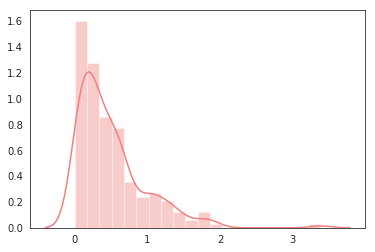

In [57]:
# pvals_t_test1=pvals_t_test
# pvals_sep_logR1=pvals_sep_logR
# pvals1=pvals

plt.figure()
pvals_t_test_gene1=pvals_t_test_gene
pvals_logr_gene1=pvals_logr_gene
# sns.distplot(-np.log10(pvals_t_test_gene1),hist=True,color='r')
ax=sns.distplot(-np.log10(pvals_t_test_gene1),hist=True,color='lightcoral',)

sns.distplot(-np.log10(pvals_sep_logR1))
sns.distplot(-np.log10(pvals1))
# sns.distplot(-np.log10(pvals_t_test1),hist=False,color='k')


yy=ax.get_ylim()
plt.vlines(-np.log10(bB1[1]),ymin=yy[0],ymax=yy[1],color='r',linestyles='--')
plt.vlines(-np.log10(cC1[1]),ymin=yy[0],ymax=yy[1],color='royalblue',linestyles='--')
plt.vlines(-np.log10(aA1[1]),ymin=yy[0],ymax=yy[1],color='darkorange',linestyles='--')

plt.ylim(yy)
plt.xlim([-0.05,10])

plt.show()

### Cyto-Mem

In [ ]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_cyto.shape[0])
    randperm2A=np.random.permutation(X_mem.shape[0])
    #positive control 

    X1=X_cyto[randperm1A[:samples],:]
    X2=X_mem[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval[0]]
    pvals_t_test_gene+=[tpval[2]]
    
    Ag=logr_gene(ecidx,X1,X2)
    pvals_logr_gene+=[Ag[1]]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t gene pval=',Ag[1])
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n gene Avg. p-value: ",np.mean(pvals_logr_gene))

In [ ]:
# pvals_t_test2=pvals_t_test
# pvals_sep_logR2=pvals_sep_logR
# pvals2=pvals

plt.figure()
pvals_t_test_gene2=pvals_t_test_gene
pvals_logr_gene2=pvals_logr_gene
# sns.distplot(-np.log10(pvals_t_test_gene2),hist=True,color='r')
sns.distplot(-np.log10(pvals_t_test_gene2),hist=True,color='lightcoral',)

sns.distplot(-np.log10(pvals_sep_logR2))
sns.distplot(-np.log10(pvals2))
# sns.distplot(-np.log10(pvals_t_test2),hist=False,color='k')


yy=ax.get_ylim()
plt.vlines(-np.log10(bB2[1]),ymin=yy[0],ymax=yy[1],color='r',linestyles='--')
plt.vlines(-np.log10(cC2[1]),ymin=yy[0],ymax=yy[1],color='royalblue',linestyles='--')
plt.vlines(-np.log10(aA2[1]),ymin=yy[0],ymax=yy[1],color='darkorange',linestyles='--')

plt.ylim(yy)
plt.xlim([-0.05,10])

plt.show()

### Naive-Cyto

In [ ]:
np.random.seed(0)
samples=3000
carlo=200
pvals=[]
pvals_t_test=[]
pvals_sep_logR=[]
for monte in range(carlo):
    randperm1A=np.random.permutation(X_naive.shape[0])
    randperm2A=np.random.permutation(X_cyto.shape[0])
    #positive control 

    X1=X_naive[randperm1A[:samples],:]
    X2=X_cyto[randperm2A[:samples],:]


    # print(X1.shape)
    # print(X2.shape)

    N1=X1.shape[0]
    N2=X2.shape[0]


    A=logr_ecidx(ecidx,X1,X2)
    
    pvals+=[A[1]]
    tpval=ttest_ecidx(ecidx,X1,X2)
    pvals_t_test+=[tpval[0]]
    pvals_t_test_gene+=[tpval[2]]
    
    Ag=logr_gene(ecidx,X1,X2)
    pvals_logr_gene+=[Ag[1]]
    
    
    
    
    pvals_tmp=[]
    for j in ecidx:
        B=logr_ecidx([j],X1,X2)
        pvals_tmp+=[B[1]]
    pval_sep=np.min([1,np.min(np.array(pvals_tmp))*len(ecidx)])
    pvals_sep_logR+=[pval_sep]
    
    print(monte,'\t logr pval=',A[1],'\t sepLR pval=',pval_sep,'\t gene pval=',Ag[1])
    
    
print("\n logR Avg. p-value: ",np.mean(pvals))
print("\n seplogR Avg. p-value: ",np.mean(pvals_sep_logR))
print("\n gene Avg. p-value: ",np.mean(pvals_logr_gene))

In [ ]:
# pvals_t_test3=pvals_t_test
# pvals_sep_logR3=pvals_sep_logR
# pvals3=pvals

plt.figure()
pvals_t_test_gene3=pvals_t_test_gene
pvals_logr_gene3=pvals_logr_gene
# sns.distplot(-np.log10(pvals_t_test_gene3),hist=True,color='r')
sns.distplot(-np.log10(pvals_t_test_gene3),hist=True,color='lightcoral',)

sns.distplot(-np.log10(pvals_sep_logR3))
sns.distplot(-np.log10(pvals3))
# sns.distplot(-np.log10(pvals_t_test3),hist=False,color='k')


yy=ax.get_ylim()
plt.vlines(-np.log10(bB3[1]),ymin=yy[0],ymax=yy[1],color='r',linestyles='--')
plt.vlines(-np.log10(cC3[1]),ymin=yy[0],ymax=yy[1],color='royalblue',linestyles='--')
plt.vlines(-np.log10(aA3[1]),ymin=yy[0],ymax=yy[1],color='darkorange',linestyles='--')

plt.ylim(yy)
plt.xlim([-0.05,10])

plt.show()